# 1 Configuring the Data

*In this module we will use Deep Learning techniques to predict the duration of taxi trips in NYC.*

## 1.1 Exploratory Data Analysis

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='./data/'

In [3]:
!ls {PATH}

accidents_2016.csv
accidents_2016.csv.zip
combined table with neighborhood and boro information.csv
fastest_routes_test.csv
fastest_routes_test.csv.zip
fastest_routes_train_part_1.csv
fastest_routes_train_part_1.csv.zip
fastest_routes_train_part_2.csv
fastest_routes_train_part_2.csv.zip
gasoline.csv
KNYC_Metars.csv
models
sample_submission.zip
second_fastest_routes_test.csv
second_fastest_routes_test.csv.zip
second_fastest_routes_train.csv
second_fastest_routes_train.csv.zip
test.csv
test.zip
tmp
train.csv
train.zip


**Feature Space**

*train:* training set provided by competition

*test*: test set

*fastest_routes_:* additional data containing fastest routes information calculated using OSRM techniques

*weather:* 2016 NYC weather data

In [4]:
%%time
train_table = pd.read_csv(f'{PATH}train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'],
                          infer_datetime_format=True, low_memory=False)
test_table = pd.read_csv(f'{PATH}test.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True,
                         low_memory=False)
fastest_routes_trn_1 = pd.read_csv(f'{PATH}fastest_routes_train_part_1.csv', low_memory=False)
fastest_routes_trn_2 = pd.read_csv(f'{PATH}fastest_routes_train_part_2.csv', low_memory=False)
fastest_routes_test = pd.read_csv(f'{PATH}fastest_routes_test.csv', low_memory=False)
weather_table = pd.read_csv(f'{PATH}KNYC_Metars.csv', parse_dates=['Time'], low_memory=False)
boro_neighborhood_table = pd.read_csv(f'{PATH}combined table with neighborhood and boro information.csv', low_memory=False)
gasoline_price_table = pd.read_csv(f'{PATH}gasoline.csv', parse_dates=['Date'], low_memory=False)
accidents_table = pd.read_csv(f'{PATH}accidents_2016.csv', parse_dates=['datetime'], low_memory=False)

CPU times: user 33.1 s, sys: 2.38 s, total: 35.5 s
Wall time: 39.6 s


Let's kick off our EDA by taking a look at the initital raw competition data provided (before any data cleaning / feature engineering).

In [5]:
from IPython.display import HTML

In [6]:
display(train_table.head())
display(test_table.head())
display(fastest_routes_trn_1.head())
display(fastest_routes_trn_2.head())
display(fastest_routes_test.head())
display(weather_table.head())
display(boro_neighborhood_table.head())
display(gasoline_price_table.head())
display(accidents_table.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id0363241,3rd Avenue,East 79th Street,2603.4,211.8,4,3rd Avenue|3rd Avenue|East 79th Street|East 79...,606.1|1948.8|48.5|0,49.5|159.1|3.2|0,depart|fork|turn|arrive,right|slight right|left|arrive,"-73.971925,40.75418|-73.968457,40.758954|-73.9..."
1,id1188175,5th Avenue,West 30th Street,1526.9,195.0,5,5th Avenue|West 29th Street|8th Avenue|West 30...,359|858.4|79|230.4|0,52.4|106|10.9|25.7|0,depart|turn|turn|turn|arrive,none|right|right|right|arrive,"-73.984788,40.748127|-73.986846,40.745301|-73...."
2,id3584231,2nd Avenue,Thompson Street,2564.9,341.0,8,2nd Avenue|East 13th Street|5th Avenue|Washing...,688.4|836.5|496.1|164.2|154.9|154.2|70.7|0,84.5|109|69.9|25.8|24.7|19.3|7.8|0,depart|turn|turn|end of road|continue|continue...,right|right|left|right|left|left|right|arrive,"-73.981498,40.737077|-73.985444,40.731658|-73...."
3,id3283815,Lexington Avenue,East 84th Street,3886.2,331.9,7,Lexington Avenue|East 49th Street|Park Avenue|...,37|147.7|78.6|745.6|2755.9|121.4|0,6.6|13.8|9.2|62.1|222.8|17.4|0,depart|turn|turn|turn|turn|turn|arrive,right|right|right|right|left|right|arrive,"-73.972608,40.756161|-73.97282,40.75587|-73.97..."
4,id0420326,West 16th Street,West 31st Street,1706.4,235.7,4,West 16th Street|6th Avenue|West 31st Street|W...,288.4|1170.4|247.6|0,41.7|166.3|27.7|0,depart|turn|turn|arrive,none|left|left|arrive,"-73.998865,40.739945|-73.995874,40.738686|-73...."


,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id0771704,6th Avenue,10th Avenue,1497.1,200.2,7,6th Avenue|West 17th Street|9th Avenue|9th Ave...,188.7|825.1|96.4|58.6|267.5|60.7|0,32.4|103.7|12.7|10.7|34|6.7|0,depart|turn|turn|continue|turn|turn|arrive,left|left|left|slight right|right|right|arrive,"-73.996527,40.737786|-73.995446,40.739272|-74...."
1,id3274209,5th Avenue,5th Avenue,1427.1,141.5,2,5th Avenue|5th Avenue,1427.1|0,141.5|0,depart|arrive,none|arrive,"-73.976974,40.75885|-73.98516,40.747618"
2,id2756455,East 18th Street,Park Avenue,2312.3,324.6,9,East 18th Street|Irving Place|East 19th Street...,19.3|74.1|148.9|632.1|163.9|1111.5|144.7|17.7|0,9.6|15.6|20.7|92.1|24.4|136.2|24.9|1.1|0,depart|turn|turn|turn|turn|turn|turn|turn|arrive,left|left|left|right|left|right|right|right|ar...,"-73.987161,40.736551|-73.986961,40.736466|-73...."
3,id3684027,Madison Avenue,6th Avenue,931.8,84.2,4,Madison Avenue|East 49th Street|6th Avenue|6th...,199.3|466.6|265.8|0,24.4|36.5|23.3|0,depart|turn|turn|arrive,right|left|right|arrive,"-73.977191,40.755664|-73.976045,40.757232|-73...."
4,id3101285,Madison Avenue,West 83rd Street,2501.7,294.7,8,Madison Avenue|East 91st Street|5th Avenue|86t...,31|154.9|491|907.6|272.1|248|397.2|0,9.4|29.7|46|103.6|25.1|21.8|59.1|0,depart|turn|turn|turn|new name|turn|turn|arrive,right|left|left|right|straight|left|right|arrive,"-73.956667,40.783797|-73.956489,40.784041|-73...."


,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast


,Unnamed: 0,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_boro,pickup_boro_code,pickup_neighborhood_name,pickup_neighborhood_code,dropoff_boro,dropoff_boro_code,dropoff_neighborhood_name,dropoff_neighborhood_code
0,1,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Manhattan,1.0,Lincoln Square,MN14,Manhattan,1.0,Upper East Side-Carnegie Hill,MN40
1,2,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Manhattan,1.0,Murray Hill-Kips Bay,MN20,Manhattan,1.0,West Village,MN23
2,3,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Manhattan,1.0,Midtown-Midtown South,MN17,Manhattan,1.0,Battery Park City-Lower Manhattan,MN25
3,4,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Manhattan,1.0,SoHo-TriBeCa-Civic Center-Little Italy,MN24,Manhattan,1.0,Battery Park City-Lower Manhattan,MN25
4,5,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Manhattan,1.0,Upper West Side,MN12,Manhattan,1.0,Upper West Side,MN12


,Date,Weekly New York City Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)
0,2000-06-05,1.610
1,2000-06-12,1.650
2,2000-06-19,1.686
3,2000-06-26,1.705
4,2000-07-03,1.711


,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,datetime
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,NaN,NaN,NaN,3448403.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,2016-05-27 17:30:00
1,NaN,NaN,40.70044,-73.815332,"(40.7004397, -73.8153324)",NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,3423067.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,2016-04-27 09:04:00
2,QUEENS,11433.0,NaN,NaN,NaN,brewer boulevard,111th avenue,NaN,0.0,0.0,...,NaN,NaN,NaN,3458894.0,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,2016-06-09 11:30:00
3,QUEENS,11423.0,NaN,NaN,NaN,199th street,100th avenue,NaN,0.0,0.0,...,NaN,NaN,NaN,3459472.0,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,2016-06-07 22:06:00
4,QUEENS,11434.0,NaN,NaN,NaN,brewer boulevard,146th terrace,NaN,0.0,0.0,...,NaN,NaN,NaN,3458030.0,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,2016-06-07 22:06:00


## 1.2 Data Cleaning

In [7]:
def show_missing():
    return train_table.columns[train_table.isnull().any()].tolist()

In [8]:
train_table[show_missing()].isnull().sum().sort_values(ascending = False)

Series([], dtype: float64)

There are no missing values in our training dataset. However, since the test set does not contain a dropoff time, we will drop it from the test set too.

In [9]:
train_table.drop('dropoff_datetime', inplace=True, axis=1)

In [10]:
test_table[show_missing()].isnull().sum().sort_values(ascending = False)

Series([], dtype: float64)

In [11]:
fastest_routes_trn_1[show_missing()].isnull().sum().sort_values(ascending = False)

Series([], dtype: float64)

In [12]:
fastest_routes_trn_2[show_missing()].isnull().sum().sort_values(ascending = False)

Series([], dtype: float64)

In [13]:
fastest_routes_test[show_missing()].isnull().sum().sort_values(ascending = False)

Series([], dtype: float64)

All of our datasets are clean. We can now proceed to performing some feature engineering.

## 1.3 Feature Engineering

### Date Time Features

We can start by performing feature extraction on the date time caegories in our dataset. This step will extract useful features from the date time objects such as day of week, quarter of the year, holidays etc. Doing so will allow the neural net to learn a richer representation by using all the information that is made available through a date time object. We will use a utility method in the `fastai` library called `add_datepart` to do this

In [14]:
add_datepart(train_table, 'pickup_datetime', drop=True, time=True)

In [15]:
display(train_table.head())

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetimeYear,...,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeHour,pickup_datetimeMinute,pickup_datetimeSecond,pickup_datetimeElapsed
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,...,False,False,False,False,False,False,17,24,55,1457976295
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,...,False,False,False,False,False,False,0,43,35,1465692215
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,...,False,False,False,False,False,False,11,35,24,1453203324
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,...,False,False,False,False,False,False,19,32,31,1459971151
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,...,False,False,False,False,False,False,13,30,55,1458999055


In [16]:
train_table.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_datetimeYear',
       'pickup_datetimeMonth', 'pickup_datetimeWeek', 'pickup_datetimeDay',
       'pickup_datetimeDayofweek', 'pickup_datetimeDayofyear',
       'pickup_datetimeIs_month_end', 'pickup_datetimeIs_month_start',
       'pickup_datetimeIs_quarter_end', 'pickup_datetimeIs_quarter_start',
       'pickup_datetimeIs_year_end', 'pickup_datetimeIs_year_start',
       'pickup_datetimeHour', 'pickup_datetimeMinute', 'pickup_datetimeSecond',
       'pickup_datetimeElapsed'],
      dtype='object')

We can see the extra datetime features extracted and added to the table. We will do the same for the test table.

In [17]:
add_datepart(test_table, 'pickup_datetime', drop=True, time=True)

### Weekends

Another datetime feature that could be useful in this context is if the trip happened on a weekend. This could influence traffic conditions and in turn trip duration.

In [18]:
train_table.loc[:, 'pickup_datetimeIsweekend'] = (train_table.loc[:, 'pickup_datetimeDayofweek'] == 5) | (train_table.loc[:, 'pickup_datetimeDayofweek'] == 6)

In [19]:
test_table.loc[:, 'pickup_datetimeIsweekend'] = (test_table.loc[:, 'pickup_datetimeDayofweek'] == 5) | (test_table.loc[:, 'pickup_datetimeDayofweek'] == 6)

### Holidays

Let's add another feature that tells us if the trip happened on a holiday

In [20]:
train_table.loc[:, 'pickup_datetimeIsholiday'] = ((train_table.loc[:, 'pickup_datetimeMonth'] == 1) & (train_table.loc[:, 'pickup_datetimeDay'] == 1)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 1) & (train_table.loc[:, 'pickup_datetimeDay'] == 18)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 2) & (train_table.loc[:, 'pickup_datetimeDay'] == 12)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 2) & (train_table.loc[:, 'pickup_datetimeDay'] == 15)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 5) & (train_table.loc[:, 'pickup_datetimeDay'] == 30)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 7) & (train_table.loc[:, 'pickup_datetimeDay'] == 4)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 9) & (train_table.loc[:, 'pickup_datetimeDay'] == 5)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 10) & (train_table.loc[:, 'pickup_datetimeDay'] == 10)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 11) & (train_table.loc[:, 'pickup_datetimeDay'] == 11)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 11) & (train_table.loc[:, 'pickup_datetimeDay'] == 24)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 12) & (train_table.loc[:, 'pickup_datetimeDay'] == 25)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 12) & (train_table.loc[:, 'pickup_datetimeDay'] == 26)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 11) & (train_table.loc[:, 'pickup_datetimeDay'] == 8))


In [21]:
test_table.loc[:, 'pickup_datetimeIsholiday'] = ((test_table.loc[:, 'pickup_datetimeMonth'] == 1) & (test_table.loc[:, 'pickup_datetimeDay'] == 1)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 1) & (test_table.loc[:, 'pickup_datetimeDay'] == 18)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 2) & (test_table.loc[:, 'pickup_datetimeDay'] == 12)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 2) & (test_table.loc[:, 'pickup_datetimeDay'] == 15)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 5) & (test_table.loc[:, 'pickup_datetimeDay'] == 30)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 7) & (test_table.loc[:, 'pickup_datetimeDay'] == 4)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 9) & (test_table.loc[:, 'pickup_datetimeDay'] == 5)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 10) & (test_table.loc[:, 'pickup_datetimeDay'] == 10)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 11) & (test_table.loc[:, 'pickup_datetimeDay'] == 11)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 11) & (test_table.loc[:, 'pickup_datetimeDay'] == 24)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 12) & (test_table.loc[:, 'pickup_datetimeDay'] == 25)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 12) & (test_table.loc[:, 'pickup_datetimeDay'] == 26)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 11) & (test_table.loc[:, 'pickup_datetimeDay'] == 8))

### Rush Hour

We know that 8am - 6pm tends to be rush hour due to people commuting to work. We can define a new feature from 8am - 6pm from Mon-Fri.

In [22]:
train_table.loc[:, 'rush_hour'] = (train_table.loc[:, 'pickup_datetimeDayofweek'] <= 4) & ((train_table.loc[:, 'pickup_datetimeHour'] >= 8) & (train_table.loc[:, 'pickup_datetimeHour'] <= 18))
test_table.loc[:, 'rush_hour'] = (test_table.loc[:, 'pickup_datetimeDayofweek'] <= 4) & ((test_table.loc[:, 'pickup_datetimeHour'] >= 8) & (test_table.loc[:, 'pickup_datetimeHour'] <= 18))

### Distance 

We can now calculate distance features. Haversine distance is obviously the goto formula for distance calculation. However, since we are dealing with data from NYC, we can also include Manhattan Distance

In [23]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

In [24]:
# Haversine Distance (in km)
train_table.loc[:, 'distance_haversine'] = haversine(train_table['pickup_latitude'].values, 
                                                     train_table['pickup_longitude'].values,
                                                     train_table['dropoff_latitude'].values, 
                                                     train_table['dropoff_longitude'].values)

test_table.loc[:, 'distance_haversine'] = haversine(test_table['pickup_latitude'].values, 
                                                     test_table['pickup_longitude'].values,
                                                     test_table['dropoff_latitude'].values, 
                                                     test_table['dropoff_longitude'].values)

# Manhattan Distance
train_table.loc[:, 'distance_manhattan'] = manhattan_distance(train_table['pickup_latitude'].values, 
                                                        train_table['pickup_longitude'].values, 
                                                        train_table['dropoff_latitude'].values, 
                                                        train_table['dropoff_longitude'].values)

test_table.loc[:, 'distance_manhattan'] = manhattan_distance(test_table['pickup_latitude'].values, 
                                                        test_table['pickup_longitude'].values, 
                                                        test_table['dropoff_latitude'].values, 
                                                        test_table['dropoff_longitude'].values)

### Heading 

Given that we have latitude and longitude information, we can also add a heading calculation to the list of features

In [25]:
def heading(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [26]:
train_table.loc[:, 'heading'] = heading(train_table['pickup_latitude'].values,
                                              train_table['pickup_longitude'].values, 
                                              train_table['dropoff_latitude'].values, 
                                              train_table['dropoff_longitude'].values)

test_table.loc[:, 'heading'] = heading(test_table['pickup_latitude'].values,
                                              test_table['pickup_longitude'].values, 
                                              test_table['dropoff_latitude'].values, 
                                              test_table['dropoff_longitude'].values)

### Average Latitude/Longitude

We can also extract the average (or middle) latitude / longitude of the trip.

In [27]:
# training set
train_table.loc[:, 'avg_latitude'] = (train_table['pickup_latitude'].values 
                                      + train_table['dropoff_latitude'].values) / 2
train_table.loc[:, 'avg_longitude'] = (train_table['pickup_longitude'].values 
                                       + train_table['dropoff_longitude'].values) / 2

# test set
test_table.loc[:, 'avg_latitude'] = (test_table['pickup_latitude'].values 
                                     + test_table['dropoff_latitude'].values) / 2
test_table.loc[:, 'avg_longitude'] = (test_table['pickup_longitude'].values 
                                      + test_table['dropoff_longitude'].values) / 2

### Distance from Airport(s) 

Distance from the airport can definitely influence traffic conditions and in turn trip duration. Here we will extract another feature using the average latitude/longitude we calculated earlier. We will consider two airports, JFK and LaGuardia here. This will allow the neural net to factor this and thus arrive a richer model.

In [28]:
JFK_COORDS = (40.6413, -73.7781)
LGA_COORDS = (40.7769, -73.8740)

jfk_lat_train = []
jfk_lon_train = []

jfk_lat_test = []
jfk_lon_test = []

lga_lat_train = []
lga_lon_train = []

lga_lat_test = []
lga_lon_test = []

for _ in range(len(train_table['avg_latitude'].values)):
    jfk_lat_train.append(JFK_COORDS[0])
    jfk_lon_train.append(JFK_COORDS[1])

for _ in range(len(test_table['avg_latitude'].values)):
    jfk_lat_test.append(JFK_COORDS[0])
    jfk_lon_test.append(JFK_COORDS[1])
    
for _ in range(len(train_table['avg_longitude'].values)):
    lga_lat_train.append(LGA_COORDS[0])
    lga_lon_train.append(LGA_COORDS[1])
    
for _ in range(len(test_table['avg_longitude'].values)):
    lga_lat_test.append(LGA_COORDS[0])
    lga_lon_test.append(LGA_COORDS[1])

In [29]:
# pickup distance from JFK
train_table.loc[:, 'pickup_distance_jfk'] = haversine(train_table['pickup_latitude'].values, 
                                               train_table['pickup_longitude'].values,
                                               jfk_lat_train, 
                                               jfk_lon_train)

test_table.loc[:, 'pickup_distance_jfk'] = haversine(test_table['pickup_latitude'].values, 
                                              test_table['pickup_longitude'].values,
                                              jfk_lat_test, 
                                              jfk_lon_test)

# avg distance from LGA
train_table.loc[:, 'pickup_distance_lga'] = haversine(train_table['pickup_latitude'].values,
                                               train_table['pickup_longitude'].values,
                                               lga_lat_train,
                                               lga_lon_train)

test_table.loc[:, 'pickup_distance_lga'] = haversine(test_table['pickup_latitude'].values,
                                              test_table['pickup_longitude'].values,
                                              lga_lat_test,
                                              lga_lon_test)

In [30]:
# avg distance from JFK
train_table.loc[:, 'avg_distance_jfk'] = haversine(train_table['avg_latitude'].values, 
                                               train_table['avg_longitude'].values,
                                               jfk_lat_train, 
                                               jfk_lon_train)

test_table.loc[:, 'avg_distance_jfk'] = haversine(test_table['avg_latitude'].values, 
                                              test_table['avg_longitude'].values,
                                              jfk_lat_test, 
                                              jfk_lon_test)

# avg distance from LGA
train_table.loc[:, 'avg_distance_lga'] = haversine(train_table['avg_latitude'].values,
                                               train_table['avg_longitude'].values,
                                               lga_lat_train,
                                               lga_lon_train)

test_table.loc[:, 'avg_distance_lga'] = haversine(test_table['avg_latitude'].values,
                                              test_table['avg_longitude'].values,
                                              lga_lat_test,
                                              lga_lon_test)

In [31]:
# dropoff distance from JFK
train_table.loc[:, 'dropoff_distance_jfk'] = haversine(train_table['dropoff_latitude'].values, 
                                               train_table['dropoff_longitude'].values,
                                               jfk_lat_train, 
                                               jfk_lon_train)

test_table.loc[:, 'dropoff_distance_jfk'] = haversine(test_table['dropoff_latitude'].values, 
                                              test_table['dropoff_longitude'].values,
                                              jfk_lat_test, 
                                              jfk_lon_test)

# avg distance from LGA
train_table.loc[:, 'dropoff_distance_lga'] = haversine(train_table['dropoff_latitude'].values,
                                               train_table['dropoff_longitude'].values,
                                               lga_lat_train,
                                               lga_lon_train)

test_table.loc[:, 'dropoff_distance_lga'] = haversine(test_table['dropoff_latitude'].values,
                                              test_table['dropoff_longitude'].values,
                                              lga_lat_test,
                                              lga_lon_test)

### Airport Trip

Another feature we can engineer is to determine if the trip was a pickup/dropoff to/from the airport as there can be heavy congestion near the airports. We will define an airport trip as having a pickup/dropoff point <2km from one of the two airports above.

In [32]:
train_table.loc[:, 'airport_trip'] = (train_table.loc[:, 'pickup_distance_jfk'] < 2) | (train_table.loc[:, 'dropoff_distance_jfk'] < 2) | (train_table.loc[:, 'pickup_distance_lga'] < 2) | (train_table.loc[:, 'dropoff_distance_lga'] < 2)
test_table.loc[:, 'airport_trip'] = (test_table.loc[:, 'pickup_distance_jfk'] < 2) | (test_table.loc[:, 'dropoff_distance_jfk'] < 2) | (test_table.loc[:, 'pickup_distance_lga'] < 2) | (test_table.loc[:, 'dropoff_distance_lga'] < 2)

### Fastest Route

We will now use OSRM to calculate the fastest route distance between pickup and dropoff. Note: The distance calculations from before were only rough estimates.

*Here credit must be given to this kernel: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367/notebook for providing us a table with OSRM calculations already performed*

In [33]:
fastest_routes_train = pd.concat((fastest_routes_trn_1, fastest_routes_trn_2))
fastest_routes_train.columns

Index(['id', 'starting_street', 'end_street', 'total_distance',
       'total_travel_time', 'number_of_steps', 'street_for_each_step',
       'distance_per_step', 'travel_time_per_step', 'step_maneuvers',
       'step_direction', 'step_location_list'],
      dtype='object')

In [34]:
osrm_drop_cols = ['starting_street', 'end_street', 'street_for_each_step','distance_per_step', 
                  'travel_time_per_step', 'step_maneuvers', 'step_direction', 'step_location_list']

for col in osrm_drop_cols:
    fastest_routes_train.drop(col, inplace=True, axis=1)
    fastest_routes_test.drop(col, inplace=True, axis=1)

In [35]:
display(fastest_routes_train.head())
display(fastest_routes_test.head())

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


,id,total_distance,total_travel_time,number_of_steps
0,id0771704,1497.1,200.2,7
1,id3274209,1427.1,141.5,2
2,id2756455,2312.3,324.6,9
3,id3684027,931.8,84.2,4
4,id3101285,2501.7,294.7,8


In [36]:
# merge these into the main train/test tables
train_table = train_table.merge(fastest_routes_train, how='left', on='id')
test_table = test_table.merge(fastest_routes_test, how='left', on='id')

### Speed

We can also calculate average speed during the trip

In [37]:
# train_table.loc[:, 'avg_speed'] = train_table['total_distance'] / train_table['total_travel_time']
# test_table.loc[:, 'avg_speed'] = test_table['total_distance'] / test_table['total_travel_time']

### Weather 

Taking weather conditions on the day of the trip into account will help improve our model

In [38]:
add_datepart(weather_table, 'Time', drop=True, time=True)

In [39]:
# extract snow feature
weather_table.loc[:, 'did_snow'] =  (weather_table.loc[:, 'Events'] == 'Snow') | (weather_table.loc[:, 'Events'] == 'Fog\n\t,\nSnow')

In [40]:
# extract rain feature
weather_table.loc[:, 'did_rain'] =  (weather_table.loc[:, 'Events'] == 'Rain') | (weather_table.loc[:, 'Events'] == 'Fog\n\t,\nRain')

In [41]:
# extract fog feature
weather_table.loc[:, 'was_foggy'] = (weather_table.loc[:, 'Events'] == 'Fog') | (weather_table.loc[:, 'Events'] == 'Fog\n\t,\nSnow') | (weather_table.loc[:, 'Events'] == 'Fog\n\t,\nRain')

In [42]:
weather_table.columns

Index(['Temp.', 'Windchill', 'Heat Index', 'Humidity', 'Pressure', 'Dew Point',
       'Visibility', 'Wind Dir', 'Wind Speed', 'Gust Speed', 'Precip',
       'Events', 'Conditions', 'TimeYear', 'TimeMonth', 'TimeWeek', 'TimeDay',
       'TimeDayofweek', 'TimeDayofyear', 'TimeIs_month_end',
       'TimeIs_month_start', 'TimeIs_quarter_end', 'TimeIs_quarter_start',
       'TimeIs_year_end', 'TimeIs_year_start', 'TimeHour', 'TimeMinute',
       'TimeSecond', 'TimeElapsed', 'did_snow', 'did_rain', 'was_foggy'],
      dtype='object')

In [43]:
weather_table = weather_table[weather_table['TimeYear'] == 2016][['TimeMonth', 'TimeDay', 'TimeHour', 'did_snow', 'did_rain', 'was_foggy', 'Wind Speed', 'Precip', 'Visibility']]

In [44]:
# rename columns to match main dataframe
weather_table.columns = ['pickup_datetimeMonth', 'pickup_datetimeDay', 'pickup_datetimeHour', 'did_snow', 'did_rain', 'was_foggy', 'wind_speed', 'precip', 'visibility']

In [45]:
weather_table.head()

,pickup_datetimeMonth,pickup_datetimeDay,pickup_datetimeHour,did_snow,did_rain,was_foggy,wind_speed,precip,visibility
22,1,1,0,False,False,False,11.1,0.0,16.1
23,1,1,1,False,False,False,7.4,0.0,16.1
24,1,1,2,False,False,False,7.4,0.0,16.1
25,1,1,3,False,False,False,5.6,0.0,16.1
26,1,1,4,False,False,False,7.4,0.0,16.1


In [46]:
# merge onto train/test dataframes
train_table = pd.merge(train_table, weather_table, on=['pickup_datetimeMonth', 'pickup_datetimeDay', 'pickup_datetimeHour'], how='left')
test_table = pd.merge(test_table, weather_table, on=['pickup_datetimeMonth', 'pickup_datetimeDay', 'pickup_datetimeHour'], how='left')

### Boro and Neighborhood Information

In [47]:
boro_neighborhood_table = boro_neighborhood_table[['id', 'pickup_boro_code', 'pickup_neighborhood_code']]
display(boro_neighborhood_table.head())

,id,pickup_boro_code,pickup_neighborhood_code
0,id2875421,1.0,MN14
1,id2377394,1.0,MN20
2,id3858529,1.0,MN17
3,id3504673,1.0,MN24
4,id2181028,1.0,MN12


In [48]:
train_table = pd.merge(train_table, boro_neighborhood_table, on=['id'], how='left')
test_table = pd.merge(test_table, boro_neighborhood_table, on='id', how='left')

### Gasoline Price

In [49]:
add_datepart(gasoline_price_table, 'Date', drop=True)
gasoline_price_table.head()

,Weekly New York City Regular All Formulations Retail Gasoline Prices (Dollars per Gallon),Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1.610,2000.0,6.0,23.0,5.0,0.0,157.0,False,False,False,False,False,False,960163200
1,1.650,2000.0,6.0,24.0,12.0,0.0,164.0,False,False,False,False,False,False,960768000
2,1.686,2000.0,6.0,25.0,19.0,0.0,171.0,False,False,False,False,False,False,961372800
3,1.705,2000.0,6.0,26.0,26.0,0.0,178.0,False,False,False,False,False,False,961977600
4,1.711,2000.0,7.0,27.0,3.0,0.0,185.0,False,False,False,False,False,False,962582400


In [50]:
gasoline_price_table.columns =  ['gas_price',
       'pickup_datetimeYear', 'pickup_datetimeMonth', 'pickup_datetimeWeek', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed']

In [51]:
gasoline_price_table = gasoline_price_table[gasoline_price_table['pickup_datetimeYear'] == 2016]
gasoline_price_table = gasoline_price_table[['gas_price', 'pickup_datetimeYear', 'pickup_datetimeMonth', 
                                             'pickup_datetimeWeek']]
gasoline_price_table.head(10)

,gas_price,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek
813,2.001,2016.0,1.0,1.0
814,1.980,2016.0,1.0,2.0
815,1.914,2016.0,1.0,3.0
816,1.886,2016.0,1.0,4.0
817,1.857,2016.0,2.0,5.0
818,1.821,2016.0,2.0,6.0
819,1.756,2016.0,2.0,7.0
820,1.744,2016.0,2.0,8.0
821,1.721,2016.0,2.0,9.0
822,1.732,2016.0,3.0,10.0


In [52]:
train_table = pd.merge(train_table, gasoline_price_table, 
                       on=['pickup_datetimeYear', 'pickup_datetimeMonth', 'pickup_datetimeWeek'], how='left')
test_table = pd.merge(test_table, gasoline_price_table, 
                       on=['pickup_datetimeYear', 'pickup_datetimeMonth', 'pickup_datetimeWeek'], how='left')

### Extreme Weather

Here we will account for more extreme weather factors like blizzards etc. The data for this section was obtained from: https://www.weather.gov/okx/stormevents 

In [53]:
train_table.loc[:, 'extreme_weather'] = ((train_table.loc[:, 'pickup_datetimeMonth'] == 1) & (train_table.loc[:, 'pickup_datetimeDay'] == 10)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 1) & (train_table.loc[:, 'pickup_datetimeDay'] == 13)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 1) & (train_table.loc[:, 'pickup_datetimeDay'] == 17)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 1) & (train_table.loc[:, 'pickup_datetimeDay'] == 23)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 2) & (train_table.loc[:, 'pickup_datetimeDay'] == 5)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 2) & (train_table.loc[:, 'pickup_datetimeDay'] == 8)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 2) & (train_table.loc[:, 'pickup_datetimeDay'] == 15)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 2) & (train_table.loc[:, 'pickup_datetimeDay'] == 16)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 2) & (train_table.loc[:, 'pickup_datetimeDay'] == 24)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 2) & (train_table.loc[:, 'pickup_datetimeDay'] == 25)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 3) & (train_table.loc[:, 'pickup_datetimeDay'] == 14)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 3) & (train_table.loc[:, 'pickup_datetimeDay'] == 15)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 3) & (train_table.loc[:, 'pickup_datetimeDay'] == 28)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 3) & (train_table.loc[:, 'pickup_datetimeDay'] == 29)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 4) & (train_table.loc[:, 'pickup_datetimeDay'] == 3)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 4) & (train_table.loc[:, 'pickup_datetimeDay'] == 4)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 5) & (train_table.loc[:, 'pickup_datetimeDay'] == 30)) | ((train_table.loc[:, 'pickup_datetimeMonth'] == 6) & (train_table.loc[:, 'pickup_datetimeDay'] == 28))
test_table.loc[:, 'extreme_weather'] = ((test_table.loc[:, 'pickup_datetimeMonth'] == 1) & (test_table.loc[:, 'pickup_datetimeDay'] == 10)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 1) & (test_table.loc[:, 'pickup_datetimeDay'] == 13)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 1) & (test_table.loc[:, 'pickup_datetimeDay'] == 17)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 1) & (test_table.loc[:, 'pickup_datetimeDay'] == 23)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 2) & (test_table.loc[:, 'pickup_datetimeDay'] == 5)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 2) & (test_table.loc[:, 'pickup_datetimeDay'] == 8)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 2) & (test_table.loc[:, 'pickup_datetimeDay'] == 15)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 2) & (test_table.loc[:, 'pickup_datetimeDay'] == 16)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 2) & (test_table.loc[:, 'pickup_datetimeDay'] == 24)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 2) & (test_table.loc[:, 'pickup_datetimeDay'] == 25)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 3) & (test_table.loc[:, 'pickup_datetimeDay'] == 14)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 3) & (test_table.loc[:, 'pickup_datetimeDay'] == 15)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 3) & (test_table.loc[:, 'pickup_datetimeDay'] == 28)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 3) & (test_table.loc[:, 'pickup_datetimeDay'] == 29)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 4) & (test_table.loc[:, 'pickup_datetimeDay'] == 3)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 4) & (test_table.loc[:, 'pickup_datetimeDay'] == 4)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 5) & (test_table.loc[:, 'pickup_datetimeDay'] == 30)) | ((test_table.loc[:, 'pickup_datetimeMonth'] == 6) & (test_table.loc[:, 'pickup_datetimeDay'] == 28))


## 1.4 Review Final Data

Before we move on, let us take one last look at the data

In [54]:
display(train_table.T.head(100))
display(test_table.T.head(100))

,0,1,2,3,4,5,6,7,8,9,...,1458634,1458635,1458636,1458637,1458638,1458639,1458640,1458641,1458642,1458643
id,id2875421,id2377394,id3858529,id3504673,id2181028,id0801584,id1813257,id1324603,id1301050,id0012891,...,id3445276,id3027038,id0405770,id1920898,id1454193,id2376096,id1049543,id2304944,id2714485,id1209952
vendor_id,2,1,2,2,2,2,1,2,1,2,...,1,2,2,1,2,2,1,2,1,1
passenger_count,1,1,1,1,1,6,4,1,1,1,...,2,1,1,1,5,4,1,1,1,1
pickup_longitude,-73.9822,-73.9804,-73.979,-74.01,-73.9731,-73.9829,-73.969,-73.9693,-73.9995,-73.981,...,-73.9891,-73.9854,-73.8638,-73.9754,-73.9888,-73.9822,-74.0009,-73.9591,-73.9821,-73.9795
pickup_latitude,40.7679,40.7386,40.7639,40.72,40.7932,40.7422,40.7578,40.7978,40.7384,40.7443,...,40.7305,40.763,40.7697,40.7517,40.7366,40.7455,40.7474,40.7688,40.7491,40.7817
dropoff_longitude,-73.9646,-73.9995,-74.0053,-74.0123,-73.9729,-73.9921,-73.9574,-73.9225,-73.9858,-73.973,...,-73.9639,-73.9897,-73.8644,-73.9495,-73.9892,-73.9949,-73.9702,-74.0044,-73.9746,-73.9728
dropoff_latitude,40.7656,40.7312,40.7101,40.7067,40.7825,40.7492,40.7659,40.7606,40.7328,40.79,...,40.7737,40.7675,40.7613,40.7768,40.7574,40.7402,40.7965,40.7074,40.7571,40.7906
store_and_fwd_flag,N,N,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
trip_duration,455,663,2124,429,435,443,341,1551,255,1225,...,972,237,800,760,414,778,655,764,373,198
pickup_datetimeYear,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016


,0,1,2,3,4,5,6,7,8,9,...,625124,625125,625126,625127,625128,625129,625130,625131,625132,625133
id,id3004672,id3505355,id1217141,id2150126,id1598245,id0668992,id1765014,id0898117,id3905224,id1543102,...,id1901191,id0664662,id2073829,id0328287,id1340822,id3008929,id3700764,id2568735,id1384355,id0621643
vendor_id,1,1,1,2,1,1,1,1,2,2,...,1,1,1,1,1,1,1,1,1,2
passenger_count,1,1,1,1,1,1,1,2,2,1,...,1,1,1,2,1,1,1,2,1,2
pickup_longitude,-73.9881,-73.9642,-73.9974,-73.9561,-73.9702,-73.9913,-73.9783,-74.0127,-73.9923,-73.9932,...,-73.9889,-73.969,-74.0026,-73.9521,-73.9732,-74.0035,-74.0064,-73.9723,-73.9765,-73.9818
pickup_latitude,40.732,40.68,40.7376,40.7719,40.7615,40.7498,40.7416,40.7015,40.7305,40.7488,...,40.7188,40.7909,40.7336,40.7774,40.764,40.7251,40.7438,40.7599,40.7336,40.7169
dropoff_longitude,-73.9902,-73.9598,-73.9862,-73.9864,-73.9615,-73.9805,-73.9521,-73.9865,-73.8756,-73.9793,...,-73.9725,-73.9677,-73.999,-73.9585,-73.9745,-74.0013,-73.9534,-73.8766,-73.8543,-73.9693
dropoff_latitude,40.7567,40.6554,40.7295,40.7305,40.7559,40.7865,40.717,40.7195,40.8752,40.7613,...,40.7435,40.7611,40.7445,40.7643,40.7572,40.7336,40.7825,40.7487,40.8918,40.7694
store_and_fwd_flag,N,N,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
pickup_datetimeYear,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
pickup_datetimeMonth,6,6,6,6,6,6,6,6,6,6,...,1,1,1,1,1,1,1,1,1,1


In [55]:
train_table.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_datetimeYear',
       'pickup_datetimeMonth', 'pickup_datetimeWeek', 'pickup_datetimeDay',
       'pickup_datetimeDayofweek', 'pickup_datetimeDayofyear',
       'pickup_datetimeIs_month_end', 'pickup_datetimeIs_month_start',
       'pickup_datetimeIs_quarter_end', 'pickup_datetimeIs_quarter_start',
       'pickup_datetimeIs_year_end', 'pickup_datetimeIs_year_start',
       'pickup_datetimeHour', 'pickup_datetimeMinute', 'pickup_datetimeSecond',
       'pickup_datetimeElapsed', 'pickup_datetimeIsweekend',
       'pickup_datetimeIsholiday', 'rush_hour', 'distance_haversine',
       'distance_manhattan', 'heading', 'avg_latitude', 'avg_longitude',
       'pickup_distance_jfk', 'pickup_distance_lga', 'avg_distance_jfk',
       'avg_distance_lga', 'dropoff_distance_jfk', 'dropoff_distance_lga',
       'airpo

In [56]:
test_table.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_datetimeYear', 'pickup_datetimeMonth',
       'pickup_datetimeWeek', 'pickup_datetimeDay', 'pickup_datetimeDayofweek',
       'pickup_datetimeDayofyear', 'pickup_datetimeIs_month_end',
       'pickup_datetimeIs_month_start', 'pickup_datetimeIs_quarter_end',
       'pickup_datetimeIs_quarter_start', 'pickup_datetimeIs_year_end',
       'pickup_datetimeIs_year_start', 'pickup_datetimeHour',
       'pickup_datetimeMinute', 'pickup_datetimeSecond',
       'pickup_datetimeElapsed', 'pickup_datetimeIsweekend',
       'pickup_datetimeIsholiday', 'rush_hour', 'distance_haversine',
       'distance_manhattan', 'heading', 'avg_latitude', 'avg_longitude',
       'pickup_distance_jfk', 'pickup_distance_lga', 'avg_distance_jfk',
       'avg_distance_lga', 'dropoff_distance_jfk', 'dropoff_distance_lga',
       'airport_trip', 'total_

# 2 Deep Learning Approach

## 2.1 Setup

Now, we need to convert our input to make it compatible with a neural network. This includes converting categorical variables into contiguous integers using embedding matrices, normalizing continuous features to standard normal (since neural nets work better when floating point numerical values are between 0 and 1) etc.

In [57]:
# categorical variables in the dataset
categorical_vars_train = ['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_datetimeYear', 
                          'pickup_datetimeMonth', 'pickup_datetimeWeek', 'pickup_datetimeDay', 
                          'pickup_datetimeDayofweek', 'pickup_datetimeDayofyear', 'pickup_datetimeIs_month_end', 
                          'pickup_datetimeIs_month_start', 'pickup_datetimeIs_quarter_end', 
                          'pickup_datetimeIs_quarter_start', 'pickup_datetimeIs_year_end', 
                          'pickup_datetimeIs_year_start', 'number_of_steps', 'pickup_datetimeHour', 
                          'pickup_datetimeMinute', 'pickup_datetimeSecond', 'pickup_datetimeIsweekend',
                          'pickup_datetimeIsholiday', 'did_snow', 'did_rain', 'was_foggy', 'pickup_boro_code', 
                          'pickup_neighborhood_code', 'extreme_weather', 'rush_hour', 'airport_trip']

categorical_vars_test = ['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_datetimeYear', 
                         'pickup_datetimeMonth', 'pickup_datetimeWeek', 'pickup_datetimeDay', 
                         'pickup_datetimeDayofweek', 'pickup_datetimeDayofyear', 'pickup_datetimeIs_month_end', 
                         'pickup_datetimeIs_month_start', 'pickup_datetimeIs_quarter_end', 
                         'pickup_datetimeIs_quarter_start', 'pickup_datetimeIs_year_end', 
                         'pickup_datetimeIs_year_start', 'number_of_steps', 'pickup_datetimeHour', 
                         'pickup_datetimeMinute', 'pickup_datetimeSecond', 'pickup_datetimeIsweekend', 
                         'pickup_datetimeIsholiday', 'did_snow', 'did_rain', 'was_foggy', 'pickup_boro_code', 
                         'pickup_neighborhood_code', 'extreme_weather', 'rush_hour', 'airport_trip']

In [58]:
# continuous variables in the dataset
continuous_vars_train = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                         'pickup_datetimeElapsed', 'distance_haversine', 
                         'distance_manhattan', 'heading', 'avg_latitude', 'avg_longitude', 
                         'pickup_distance_jfk', 'dropoff_distance_jfk', 'avg_distance_jfk', 'pickup_distance_lga', 
                         'dropoff_distance_lga', 'avg_distance_lga', 'total_distance', 'total_travel_time', 
                         'wind_speed', 'precip', 'visibility', 'gas_price']

continuous_vars_test = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                        'pickup_datetimeElapsed', 'distance_haversine', 'distance_manhattan', 'heading', 
                        'avg_latitude', 'avg_longitude', 'pickup_distance_jfk', 'dropoff_distance_jfk', 
                        'avg_distance_jfk', 'pickup_distance_lga', 'dropoff_distance_lga', 'avg_distance_lga',
                        'total_distance', 'total_travel_time', 'wind_speed', 'precip', 'visibility', 'gas_price']

In [59]:
len(categorical_vars_train) + len(continuous_vars_train)

51

In [60]:
len(train_table.columns)

53

In [61]:
len(categorical_vars_test) + len(continuous_vars_test)

51

In [62]:
len(test_table.columns)

52

In [63]:
num_rows_train = len(train_table); num_rows_train

1458644

We have 1458644 rows in our training set

In [64]:
dep = 'trip_duration' # the dependent variable (what we're trying to predict)

In [65]:
# tell pandas to treat categorical variables as such
for cat_var_trn in categorical_vars_train:
    train_table[cat_var_trn] = train_table[cat_var_trn].astype('category').cat.as_ordered()

for cat_var_test in categorical_vars_test:
    test_table[cat_var_test] = test_table[cat_var_test].astype('category').cat.as_ordered()

In [66]:
# apply same one-hot encoding for categorical variables in both the training and test set
apply_cats(train_table, test_table)

In [67]:
# tell pandas to treat continuous variables as 32bit floating point values as expected by pytorch
for cont_var_trn in continuous_vars_train:
    train_table[cont_var_trn] = train_table[cont_var_trn].fillna(0).astype('float32')

for cont_var_test in continuous_vars_test:
    test_table[cont_var_test] = test_table[cont_var_test].fillna(0).astype('float32')

Now we are ready to process our dataframe. This involves removing the dependent variable from the dataframe and storing it in a separate variable, creating a one-hot encoding mapping for cetegorical variables and normalizing continuous variables

In [68]:
df, y, nas, mapper = proc_df(train_table, dep, do_scale=True, skip_flds=['id'])
yl = np.log(y + 1)

In [69]:
df_test, _, nas, mapper = proc_df(test_table, do_scale=True, skip_flds=['id'], mapper=mapper, na_dict=nas)

In [70]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,...,did_snow,did_rain,was_foggy,wind_speed,precip,visibility,pickup_boro_code,pickup_neighborhood_code,gas_price,extreme_weather
0,2,2,-0.122087,0.517458,0.124375,0.384419,1,1,3,11,...,1,1,1,2.615155,0.503574,-1.472337,1,95,0.027619,2
1,1,2,-0.097553,-0.375855,-0.368964,-0.575459,1,1,6,23,...,1,1,1,-0.205812,-0.146337,0.475411,1,99,0.738154,1
2,2,2,-0.077969,0.395874,-0.451799,-1.162375,1,1,1,3,...,1,1,1,2.103509,-0.146337,0.475411,1,97,0.155232,1
3,2,2,-0.515383,-0.941310,-0.549970,-1.256227,1,1,4,14,...,1,1,1,2.352417,-0.146337,0.475411,1,103,0.276543,1
4,2,2,0.006286,1.286055,0.006981,0.855802,1,1,3,12,...,1,1,1,0.056925,-0.146337,0.475411,1,93,0.076459,1


In [71]:
y

array([ 455,  663, 2124,  429,  435,  443,  341, 1551,  255, 1225, 1274, 1128, 1114,  260, 1414,  211, 2316,
        731, 1317,  251, ...,  152, 2002,  244,  880,  351,  601,  549,  342,  777,  979,  972,  237,  800,
        760,  414,  778,  655,  764,  373,  198])

In [72]:
len(y)

1458644

In [73]:
val = get_cv_idxs(num_rows_train - 1); len(val)

291728

Since this is not a time series prediction task, it is ok to just take random indexes for validation.

In [74]:
# define competition evaluation metric
def rmsle(y_pred, targ):
    return np.sqrt(((targ - y_pred)**2).mean())

## 2.2 Training

In [75]:
md = ColumnarModelData.from_data_frame(PATH, val, df, yl.astype(np.float32), cat_flds=categorical_vars_train, bs=128, 
                                       test_df=df_test)

Now we need to determine the size of the embedding matrices for our categorical variables.

Let's begin by examining the sizes of each of our categorical variables.

In [76]:
cat_sz = [(c, len(train_table[c].cat.categories)+1) for c in categorical_vars_train] # add 1 for unknown values / NAs etc.

In [77]:
cat_sz

[('vendor_id', 3),
 ('passenger_count', 9),
 ('store_and_fwd_flag', 3),
 ('pickup_datetimeYear', 2),
 ('pickup_datetimeMonth', 7),
 ('pickup_datetimeWeek', 28),
 ('pickup_datetimeDay', 32),
 ('pickup_datetimeDayofweek', 8),
 ('pickup_datetimeDayofyear', 183),
 ('pickup_datetimeIs_month_end', 3),
 ('pickup_datetimeIs_month_start', 3),
 ('pickup_datetimeIs_quarter_end', 3),
 ('pickup_datetimeIs_quarter_start', 3),
 ('pickup_datetimeIs_year_end', 2),
 ('pickup_datetimeIs_year_start', 3),
 ('number_of_steps', 43),
 ('pickup_datetimeHour', 25),
 ('pickup_datetimeMinute', 61),
 ('pickup_datetimeSecond', 61),
 ('pickup_datetimeIsweekend', 3),
 ('pickup_datetimeIsholiday', 3),
 ('did_snow', 3),
 ('did_rain', 3),
 ('was_foggy', 3),
 ('pickup_boro_code', 6),
 ('pickup_neighborhood_code', 180),
 ('extreme_weather', 3),
 ('rush_hour', 3),
 ('airport_trip', 3)]

We use the cardinality of each variable (that is, its number of unique values) to decide how large to make its embeddings. Each level will be associated with a vector with length defined as below.

In [78]:
# rule of thumb: make embeddings half the size of the cardinality but <= 50# rule o 
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [79]:
emb_szs

[(3, 2),
 (9, 5),
 (3, 2),
 (2, 1),
 (7, 4),
 (28, 14),
 (32, 16),
 (8, 4),
 (183, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (2, 1),
 (3, 2),
 (43, 22),
 (25, 13),
 (61, 31),
 (61, 31),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (6, 3),
 (180, 50),
 (3, 2),
 (3, 2),
 (3, 2)]

In [80]:
learn = md.get_learner(emb_szs, len(df.columns)-len(categorical_vars_train),
                        0.02, 1, [1000,500], [0.001,0.01])

In [81]:
learn.lr_find()

  6%|▌         | 524/9117 [00:07<01:55, 74.30it/s, loss=7.25] 


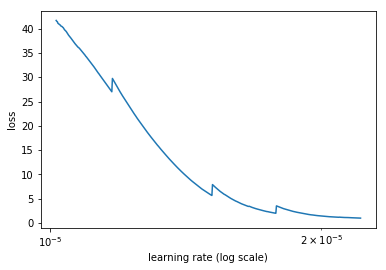

In [82]:
learn.sched.plot()

In [83]:
lr = 1.5e-5

In [96]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2, metrics=[rmsle])

epoch      trn_loss   val_loss   rmsle                         
    0      0.161526   0.159846   0.392074  
    1      0.13887    0.169598   0.401804                      
    2      0.148631   0.161536   0.393296                      
    3      0.163322   0.163138   0.395316                      
    4      0.295807   0.163134   0.393198                      
    5      0.147851   0.161397   0.393785                      
    6      0.154359   0.16       0.392233                      
    7      0.149289   0.17117    0.39861                       
    8      0.159602   0.174019   0.398628                      
    9      0.160348   0.169647   0.397062                      
    10     0.148429   0.161168   0.393328                      
    11     0.156791   0.160909   0.393339                      
    12     0.13876    0.159787   0.391992                      
    13     0.147632   0.159448   0.391554                      
    14     0.14759    0.159439   0.391538                   

[array([0.15892]), 0.39083666729951966]

## 2.3 Predict on Test Set

In [97]:
predictions = learn.predict(is_test=True)
predictions = np.exp(predictions) - 1

In [88]:
display(predictions)

array([[ 810.8101 ],
       [ 503.56815],
       [ 396.43735],
       [ 988.9449 ],
       [ 264.6046 ],
       [ 779.7321 ],
       [1118.7777 ],
       [ 801.234  ],
       [2240.2146 ],
       [ 417.99698],
       [ 856.5953 ],
       [ 373.94962],
       [ 393.56586],
       [ 636.84515],
       [1094.1084 ],
       [ 749.9462 ],
       [1087.6678 ],
       [ 454.54535],
       [ 124.51875],
       [ 913.51746],
       ...,
       [ 592.6736 ],
       [2379.119  ],
       [ 673.87555],
       [1302.4484 ],
       [1504.8839 ],
       [ 483.33643],
       [ 500.48904],
       [ 349.4126 ],
       [ 406.2985 ],
       [1214.9965 ],
       [ 657.3555 ],
       [ 818.41797],
       [ 402.6697 ],
       [ 331.86194],
       [ 272.64212],
       [ 330.32526],
       [1254.649  ],
       [1668.4913 ],
       [1393.0199 ],
       [1124.6183 ]], dtype=float32)

## 2.4 Creating a Kaggle Compatible Submission

In [89]:
len(predictions)

625134

In [90]:
len(test_table)

625134

In [91]:
test_table['trip_duration'] = predictions

In [92]:
test_table.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetimeYear,pickup_datetimeMonth,...,did_rain,was_foggy,wind_speed,precip,visibility,pickup_boro_code,pickup_neighborhood_code,gas_price,extreme_weather,trip_duration
0,id3004672,1,1,-73.988129,40.732029,-73.990173,40.756680,N,2016,6,...,False,False,0.0,0.0,16.1,1.0,MN22,2.283,False,810.810120
1,id3505355,1,1,-73.964203,40.679993,-73.959808,40.655403,N,2016,6,...,False,False,0.0,0.0,16.1,3.0,BK64,2.283,False,503.568146
2,id1217141,1,1,-73.997437,40.737583,-73.986160,40.729523,N,2016,6,...,False,False,0.0,0.0,16.1,1.0,MN23,2.283,False,396.437347
3,id2150126,2,1,-73.956070,40.771900,-73.986427,40.730469,N,2016,6,...,False,False,0.0,0.0,16.1,1.0,MN31,2.283,False,988.944885
4,id1598245,1,1,-73.970215,40.761475,-73.961510,40.755890,N,2016,6,...,False,False,0.0,0.0,16.1,1.0,MN19,2.283,False,264.604614


In [93]:
submission_df = test_table[['id', 'trip_duration']]

In [94]:
submission_df.head()

,id,trip_duration
0,id3004672,810.810120
1,id3505355,503.568146
2,id1217141,396.437347
3,id2150126,988.944885
4,id1598245,264.604614


In [ ]:
mkdir subm/

In [98]:
submission_df.to_csv(f'subm/subm16.gz', compression='gzip', index=False)